# Autoencoders

The idea behind autoencoders is to configure a neural network such that we aim to predict the same input example, why would we do this? Because we can set the network such that it has a sort of bottleneck by encoding the input into a lower dimensional representation and then using this representation to regenerate the original input. By doing so we can implement a few interesting applications:

1. Dimensionality reduction / feature extraction.
2. Because of 1 we can achieve compression of inputs.
3. Denoising of inputs.
4. Anomaly detection.
5. Search
6. Missing value imputation.
7. Generation.

Let's consider the images of the CIFAR-10 dataset, 32 x 32 RGB images belonging to a set of 10 labels, these are a few examples:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.datasets import Caltech101, CIFAR10
from torchvision.transforms import ToTensor

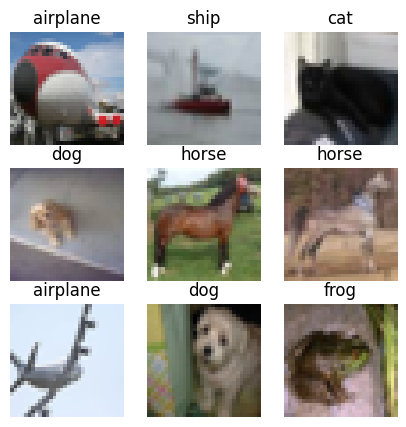

In [2]:
np.random.seed(1)

train_dataset = CIFAR10('CIFAR-10', train=True, download=True, transform=ToTensor())

labels_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(train_dataset))
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

# Autoencoder Network

Given that we are dealing with images that carry positional information we should probably build the autoencoder using a CNN, we define a simple architecture that uses an encoder with convolutional layers to reduce dimensionality and then a decoder which uses transposed convolutions to upscale the dimensionality reduction.

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3, 128, 2, stride=2),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(128, 256, 2, stride=2),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(256, 12, 1, stride=1, padding=0),  # 8 -> 8
            nn.ReLU(),
            nn.Flatten(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
hin = 8
k = 1
p = 0
s = 1

hout = (hin - k + 2*p)/s + 1
hout

8.0

In [5]:
hin = 8
k = 4
stride = 1
dilation = 0
padding = 0
opadding = 0

hout = (hin - 1)*stride - 2*padding + dilation*(k-1) + opadding + 1
hout

8

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # The encoder but reversed
        self.linear_relu_stack = nn.Sequential(
            nn.Unflatten(1, (12, 8, 8)),
            nn.ConvTranspose2d(12, 256, 4, stride=2, padding=1, dilation=1),  #  8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 3, 2, stride=2, padding=1, dilation=3),  # 16 -> 32
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        logits = self.decoder(self.encoder(x))
        return logits

### Dataloaders

Because the original dataset provides (img, label) samples but we need (img, img) samples we create a new dataset that does this.

In [6]:
from torch.utils.data import Dataset

class CIFAR10Autoencoding(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset.__getitem__(idx)
        return image, image

In [7]:
from torch.utils.data import DataLoader

train_dataset = CIFAR10('CIFAR-10', train=True, download=True, transform=ToTensor())
train_dataloader = DataLoader(CIFAR10Autoencoding(train_dataset), batch_size=8)

test_dataset = CIFAR10('CIFAR-10', train=False, transform=ToTensor())
test_dataloader = DataLoader(CIFAR10Autoencoding(test_dataset), batch_size=1)

### Training

We define both the training loop and a test loop meant for the respective dataset splits.

In [8]:
def train_loop(dataloader, model, loss, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_size = 8
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [9]:
# Declare the model, loss and optimizer
model = Autoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

In [10]:
# Run the training loop
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.394675  [    8/50000]
loss: 0.066078  [  808/50000]
loss: 0.081679  [ 1608/50000]
loss: 0.063460  [ 2408/50000]
loss: 0.070735  [ 3208/50000]
loss: 0.060980  [ 4008/50000]
loss: 0.054794  [ 4808/50000]
loss: 0.064720  [ 5608/50000]
loss: 0.067560  [ 6408/50000]
loss: 0.053699  [ 7208/50000]
loss: 0.063078  [ 8008/50000]
loss: 0.068013  [ 8808/50000]
loss: 0.057849  [ 9608/50000]
loss: 0.040188  [10408/50000]
loss: 0.047150  [11208/50000]
loss: 0.038031  [12008/50000]
loss: 0.044465  [12808/50000]
loss: 0.053527  [13608/50000]
loss: 0.040612  [14408/50000]
loss: 0.036912  [15208/50000]
loss: 0.041144  [16008/50000]
loss: 0.040961  [16808/50000]
loss: 0.032039  [17608/50000]
loss: 0.036907  [18408/50000]
loss: 0.061741  [19208/50000]
loss: 0.050280  [20008/50000]
loss: 0.027191  [20808/50000]
loss: 0.039807  [21608/50000]
loss: 0.029665  [22408/50000]
loss: 0.020938  [23208/50000]
loss: 0.033439  [24008/50000]
loss: 0.032290  [24808/50000]


In [11]:
# Generate predictions for the full test dataset
model.eval()
imgs = []
preds = []
with torch.no_grad():
    for X, y in test_dataloader:
        imgs += X
        preds += model(X).detach()

In [12]:
# Select one of the test samples and visualize
img = imgs[0]
pred = preds[0]

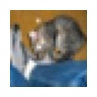

In [13]:
def plot_img(img):
    plt.figure(figsize=(1, 1))
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))

# First the target image
plot_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058800697..1.1000764].


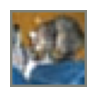

In [14]:
# Then the model's output
plot_img(pred)

Not perfect but okay for this small network, we are able to decode from a compressed representation.

### Dimensionality Reduction / Compression

By encoding the 32x32x3 (3,072 dimensional) tensor into a 8x8x12 (786 dimensional) vector we have achieved dimensionality reduction as well as compression although with introduced a loss since the decoder doesn't perfectly reconstruct the original input, we should ask ourselves if for our application we require an exact decompression or an approximate lossy compression would be useful. This also means that the better we can design the network and further reduce the loss, then our compression would be less lossy.

To obtain the compressed representation we run the encoder only and we will get the 786 dimensional vector.

In [15]:
model.encoder(img).detach().reshape(-1).shape

torch.Size([768])

### Lossy Recuperation

Can we regenerate a lossy transmission?

We can add some random noise to each pixel with the following distribution, see if our autoencoder can remove it, we can do it with the following function:

In [16]:
def add_gaussian_noise(img):
    img = img + np.random.normal(0, 0.05, img.shape)
    return img.to(dtype=torch.float32)

In [17]:
img = add_gaussian_noise(imgs[0])
pred = model(img.reshape(1, 3, 32, 32)).detach()

/tmp/ipykernel_765/212434678.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img + np.random.normal(0, 0.05, img.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042884298..1.0777508].


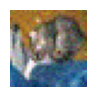

In [18]:
plot_img(img)

Above we have the noisy image and below the decoded image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.062770694..1.0984374].


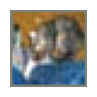

In [19]:
plot_img(pred)

Instead of gaussian noise in the pixels what if we just drop some pixels randomly, let's try that:

In [20]:
def drop_pixels(img):
    pixels_to_drop = np.random.randint(0, 32*32, 10)
    pixels_to_drop = [(i//32, i%32) for i in pixels_to_drop]
    for h, w in pixels_to_drop:
        img[:, h, w] = 0
    return img.to(dtype=torch.float32)

In [21]:
img = drop_pixels(imgs[0])
pred = model(img.reshape(1, 3, 32, 32)).detach()

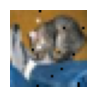

In [22]:
plot_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059398293..1.1030658].


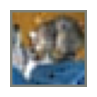

In [23]:
plot_img(pred)

It kind of works recuperating from those black empty spots but we can still see them. Notice that since we are able to generate the lossy images ourselves, we could extend the training set with examples of noisy images on the input and the actual image on the output, while not strictly autoencoding training it might help to improve these cases of lossy recuperation.

### Anomaly Detection

One way to look at anomaly detection is figuring out if a new example is in or out of distribution, and an easy way to implement such test is using a KNN model, this is interesting because so far we have been using only the network to get the functionality but now we need a memory which will store the training examples. T

To test anomalies we will pick a single class from the original 10 in CIFAR-10 training set, and then will try to see if any other class (from test) shows up as an anomaly, in other words we will be creating a knn classifier for a given class, or from the inverse perspective, a classifier for anomalies considered as anything which is not from that class.

Let's use the vector representation from the dimensionality reduction step to build the memory for the KNN classifier, we will select the class **0** which is airplanes.

In [27]:
model.eval()

with torch.no_grad():
    train_embeddings = model.encoder(
        torch.tensor(np.array([img for img, lbl in train_dataset]))
    ).detach().numpy()

Test what happens with airplane examples from test:

In [28]:
with torch.no_grad():
    test_embeddings = model.encoder(
        torch.tensor(np.array([img for img, lbl in test_dataset]))
    ).detach().numpy()

In [31]:
from sentence_transformers.util import cos_sim

test_cs = cos_sim(test_embeddings, train_embeddings).numpy()  # cosine similarity of shape (test samples, train samples)
test_knn = np.sort(test_cs, axis=-1)[:, :5].mean(axis=-1)  # Compute a 5-NN mean cos sim

For each of the airplane examples in the test set we get 5000 distances, to each of the train examples, the idea is that if the test examples are in distribution then they will be close to the train ones.

In [32]:
test_knn.shape

(10000,)

In [33]:
import pandas as pd

pd.Series(test_knn).describe()

count    10000.000000
mean         0.556921
std          0.055315
min          0.315783
25%          0.520809
50%          0.562041
75%          0.597422
max          0.700914
dtype: float64

<Axes: >

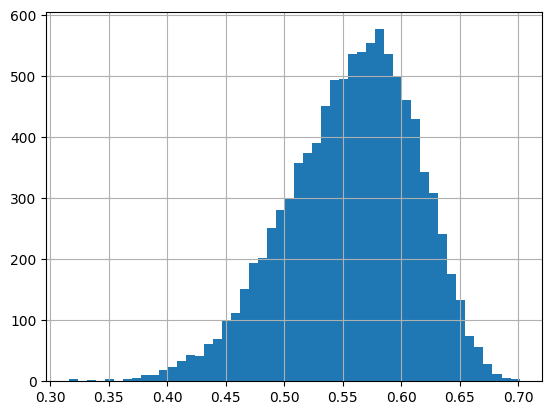

In [34]:
pd.Series(test_knn).hist(bins=50)

We obtain a normal distribution, we can check what are the test examples that result in the min (left tail) values for the knn similarity, these might be considered anomalies.

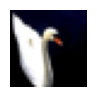

In [38]:
img = imgs[test_knn.argsort()[0]]
plot_img(img)

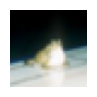

In [39]:
img = imgs[test_knn.argsort()[1]]
plot_img(img)

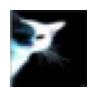

In [41]:
img = imgs[test_knn.argsort()[2]]
plot_img(img)

It seems that images with a black background might not be well represented in our dataset. We can also try new examples that will likely come up as out of distribution anomalies.